# In this project I am going to track spots in data gathered using high resolution flourescent microscopy and extract features from the overall spot trajectory (step size and dwell times for the motor protein).

The project was inspired by the fact that writing a step size finding algorithm for molecular tracking is tricky and it's highly affected by the noise due to imaging. First, I am going to track spots using gaussian fitting and then train a ML algorithm to find the spots automatically without the need for the gaussian fitting. Then, I will extract the trajectories of single spots and flag the trajectory by hand for when the motor protein steps (in this case human Dynein-Dynactin-BicD2 complex, for more information about dynein and its stepping pattern, see this review article: [by Reck-Peterson et al.](https://www.nature.com/articles/s41580-018-0004-3)). <br><br>I will use Logistic Regression to classify whether a step occurs in test trajectories. Training the ML algorithm with more data will improve the accuracy even further. Finally, the dwell time and step size distribution of the protein can be extracted using Machine Learning.

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from skimage.feature import peak_local_max
import scipy.optimize as opt



I am importing my image data from a .tiff movie using tifffile and saving the images as an ndnumpy array. The movie is composed of 100 frames. This number depends on for how long you did your flourescent imaging.

In [248]:
from tifffile import TiffFile
with TiffFile('Desktop/humanatp.tif') as tif: #human dynein image data in the presence of ATP.
    images = np.transpose(tif.asarray()).astype('float')

The images consist of 100 frames with dimentions of 160 and 116 pixels.

In [228]:
frames = images.shape[2]
images.shape

(160, 116, 100)

# Using the kernel method to detect the noise and the edges in an image.

I am convolving the images with two different functions along both directions to detect the edges in my images (basically the single spots). The convolve1d function calculates a one-dimensional convolution along the given axis. The lines of the array along the given axis are convolved with the given weights. Here, first convolution gives information about the noise, whereas the second convolution gives information about the edges in my images.<br><br>
The 2nd wavelet form can be used to detect the spots without noise. I will use this wavelet to fit my spots into a gaussian. [Here](https://www.sciencedirect.com/science/article/pii/S1877050915014234) is an article explaining how wavelet transform is used for noise reduction.

In [249]:
kern1 = np.array([1/16,1/4,3/8,1/4,1/16])
kern2 = np.array([1/16,0,1/4,0,3/8,0,1/4,0,1/16])

In [250]:
from scipy.ndimage import filters
conv1 = filters.convolve1d(filters.convolve1d(images,kern1,axis=1),kern1,axis=0)
conv2 = filters.convolve1d(filters.convolve1d(conv1,kern2,axis=1),kern2,axis=0)

In [251]:
wave1 = np.abs(images-conv1)
wave2 = np.abs(conv1-conv2)

In [252]:
first_frame = images[:,:,0]
first_wave = wave1[:,:,0]
second_wave = wave2[:,:,0]

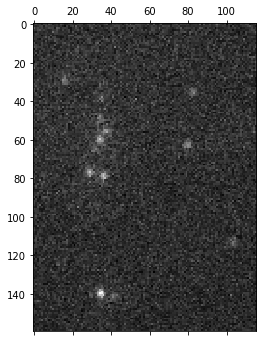

In [253]:
plt.matshow(first_frame,cmap='gray') # the original image is quite noisy.
plt.show()

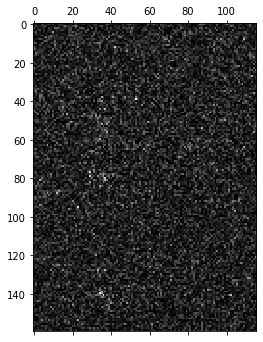

In [254]:
plt.matshow(first_wave,cmap='gray') #first wavelet is pure noise and needs to be subtracted for detection.
plt.show()

I can very clearly visualize where my spots are using the second wavelet form. I am using peak_local_max from skimage.feature to find the local maxima. I will use the first wavelet form (the noise) to determine a treshold for the peak_local_max function to find the spots.


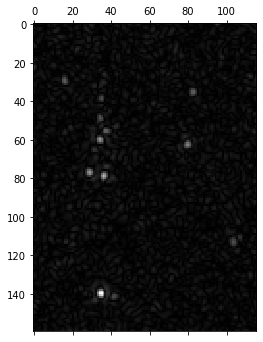

In [255]:
plt.matshow(second_wave,cmap='gray')
plt.show()

In [237]:
wave1.shape #double checking that the shape is consistent.

(160, 116, 100)

In [238]:
np.mean(wave1[:,:,0]) #the mean value for the noise is a criteria to set a treshold.

24.04119283741918

When detecting the spots using the second wavelet, I set my minimum distance between spots to 2 pixels, I would like to detect spots that are at least (mean + 1.5*std of the first wavelet) far away intensity wise, and exclude spots that are too close to edges to make sure that there are enough pixels to make a gaussian fit around.

In [256]:
spots_first_frame = peak_local_max(wave2[:,:,0],min_distance = 2, threshold_abs = np.mean(wave1[:,:,0]) + 1.5*np.std(wave1[:,:,0]), exclude_border = 10)

Plotting the spots detected in the very first frame shows that this criteria works reasonably.

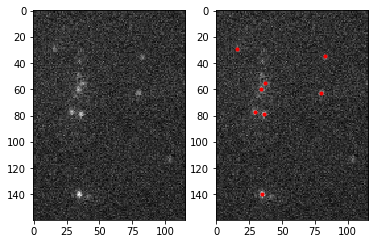

In [257]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(first_frame,cmap='gray')
plt.imshow(first_frame,cmap='gray')
plt.plot(spots_first_frame[:, 1], spots_first_frame[:, 0], 'r.')
plt.show()

I am going to collect each and every spot from every frame in an array.

In [258]:
spots = np.empty(shape=[0,3],dtype=np.int)

for i in range(frames):
    location = peak_local_max(wave2[:,:,i],min_distance = 2, threshold_abs = np.mean(wave1[:,:,i]) + 1.5*np.std(wave1[:,:,i]), exclude_border = 10)
    location = np.hstack([np.ones((len(location),1),dtype=np.int)*i,location])
    spots = np.append(spots,location,axis=0)   

Here, I am saving every spot as a 9 x 9 numpy array. Sliced1 is the 2nd wavelet form, which I will use for fitting.

In [259]:
im_size = 4
sliced = np.zeros((spots.shape[0],im_size*2+1,im_size*2+1), 'float')
sliced1 = np.zeros((spots.shape[0],im_size*2+1,im_size*2+1), 'float')


for j,i in enumerate(spots):
    temp=images[i[1]-im_size:i[1]+im_size+1,i[2]-im_size:i[2]+im_size+1,i[0]]
    temp1 = wave2[i[1]-im_size:i[1]+im_size+1,i[2]-im_size:i[2]+im_size+1,i[0]]
    sliced[j,:,:] = temp
    sliced1[j,:,:] = temp1
from tifffile import imsave
imsave('Desktop/spots.tif', sliced.T,metadata={'axes': 'XYZ'})

This is a visualization of one of the spots, and I am going to fit a gaussian fit to it.

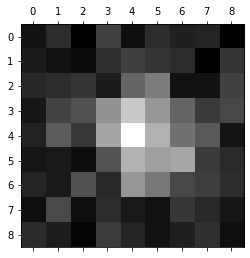

In [260]:
test = sliced[44,:,:] #the original spot
plt.matshow(test,cmap='gray')
plt.show()

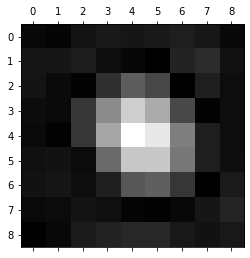

In [261]:
test = sliced1[44,:,:] #the spot without the noise looks so much nicer for this very noisy spot!
plt.matshow(test,cmap='gray')
plt.show()

In [262]:
def twoD_Gaussian(mesh, amplitude, x0, y0, sigma_x, sigma_y, offset): #defining a function for 2D Gaussian fit.
    mesh = (x, y)
    g = offset + amplitude*np.exp(-((x-x0)**2)/(2*sigma_x**2)-((y-y0)**2)/(2*sigma_y**2))
    
    return g.ravel()

In [263]:
# Create x and y indices for the fit.
x = np.linspace(0, 8, 9)
y = np.linspace(0, 8, 9)
x,y = np.meshgrid(x, y)
initial_guess = (500,4,4,1,1,800)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x,y), test.ravel(), p0 = initial_guess)



Here is a fit of a spot to the gaussian function. The fit looks good!

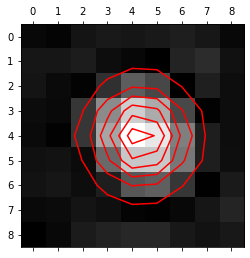

In [264]:
data_fitted = twoD_Gaussian((x, y),*popt)

plt.matshow(test, cmap=plt.cm.gray)
plt.contour(x, y, data_fitted.reshape(9, 9), 6, colors='r')
plt.show()

There are 294 spots detected in total in every frame. Note that, a protein might unbind or its signal may become weak compared to the treshold at certain frames, hence it may not be detected, but for now this is not a problem and I will account for this when I track a single molecule for 100 frames by making sure that a fit is realized for each and every frame.

In [244]:
spots.shape

(294, 3)

I am gathering each and every spot into a dataframe to use it in my ML algorithm.

In [265]:
#spots_trajectory = np.empty(shape=[0,2],dtype=np.int)
#spots_trajectory = np.append(1,spots_first_frame[0])

fitted_spots = np.empty(shape=[0,9])
    
for spot in range (spots.shape[0]):
    test1 = sliced1[spot,:,:]
    try:
        popt, pconv = opt.curve_fit(twoD_Gaussian,(x,y),test1.ravel(),p0=initial_guess)    
    except RuntimeError: #put an exception in case the gaussian fit fails.
        popt = np.array([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
    fit_param = np.resize(np.hstack([spots[spot],popt]),(1,9))
    fitted_spots = np.append(fitted_spots,fit_param,axis=0)

In [266]:
fit_info = pd.DataFrame(fitted_spots,columns=['Frame','xstart','ystart','Amplitude','xc','yc','sigma_x','sigma_y','offset'])

In [267]:
fit_info.head() #the dataframe consists of features for the spot fits.

,Frame,xstart,ystart,Amplitude,xc,yc,sigma_x,sigma_y,offset
0,0.0,140.0,35.0,168.341109,3.595833,4.007595,1.074264,1.257039,14.656508
1,0.0,79.0,36.0,117.455004,4.234112,3.936127,1.086235,1.169991,10.402490
2,0.0,77.0,29.0,96.267280,3.785493,4.181627,1.044520,1.133399,9.629731
3,0.0,63.0,80.0,80.647662,3.642418,3.736066,1.253986,1.134634,8.437299
4,0.0,60.0,34.0,90.355409,4.072362,4.203424,0.997636,1.119517,12.075083


In [268]:
train_data = sliced1 #my target variable is only x and y position so for now I am dropping the other features.
train_labels = fit_info.drop(columns = ['Frame','xstart','ystart','Amplitude','sigma_x','sigma_y','offset'])



Reshaping the train_data (9 by 9 array containing the light intensity) to feed into a regression model.

In [269]:
train_data = train_data.reshape(train_data.shape[0], 81) #reshape the input data


Scaling the data (intesities) because the bright pixels can be an order of magnitude brighter than the dark pixels, just to make sure that the algorithm has an easier time to find the center.

In [270]:
from sklearn.preprocessing import scale

for i in range(train_data.shape[0]):
    train_data[i] = (train_data[i] - np.mean(train_data[i])) / np.std(train_data[i])

Here I am splitting the data into train and test data sets to feed into a neural network. As the neural networks are preferred way to handle image classification, I first wanted to give it a try rather than other regression methods.

In [271]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=0)



I have tried many different layers, including convolutional layers to detect the spot centers but neither RNNs nor CNNs are very precise at detecting the image center. Deep learning is more useful in extracting features from an image. For instance; a neural network can easily classify if an image contains a cat by extracting different features such as whether it has eyes, a tail, legs etc. but in this case it fails to perform well.

In [273]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.utils import to_categorical

model = Sequential()

model.add(Dense(1000,activation='relu'))
model.add(Dense(1000,activation='relu'))

model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))


model.add(Dense(2,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adadelta')
model.fit(X_train,y_train.values,epochs=100) #train the network for 100 epochs 


Epoch 1/100
582/582 [==============================] - 5s 8ms/step - loss: 7.7911
Epoch 2/100
582/582 [==============================] - 1s 2ms/step - loss: 0.0847
Epoch 3/100
582/582 [==============================] - 2s 3ms/step - loss: 0.1129
Epoch 4/100
582/582 [==============================] - 2s 3ms/step - loss: 0.1503
Epoch 5/100
582/582 [==============================] - 2s 3ms/step - loss: 0.3872
Epoch 6/100
582/582 [==============================] - 2s 3ms/step - loss: 0.5692
Epoch 7/100
582/582 [==============================] - 1s 2ms/step - loss: 0.7157
Epoch 8/100
582/582 [==============================] - 1s 2ms/step - loss: 0.7392
Epoch 9/100
582/582 [==============================] - 2s 3ms/step - loss: 0.7408
Epoch 10/100
582/582 [==============================] - 2s 3ms/step - loss: 0.7975
Epoch 11/100
582/582 [==============================] - 1s 3ms/step - loss: 0.8160
Epoch 12/100
582/582 [==============================] - 1s 2ms/step - loss: 0.7033
Epoch 13/100


582/582 [==============================] - 2s 3ms/step - loss: 0.0263
Epoch 100/100
582/582 [==============================] - 2s 3ms/step - loss: 0.0093


In [274]:
preds = model.predict(X_test)

Even though the validation loss decreases substantially after many epochs, the difference between the predictions and test values are too high to track the spots precisely.

In [275]:
preds[:5]

array([[4.491459 , 4.3106465],
       [3.791407 , 4.430593 ],
       [4.163996 , 3.8172686],
       [4.3458176, 3.754958 ],
       [4.0550756, 3.8861332]], dtype=float32)

In [276]:
y_test[:5]

,xc,yc
320,4.325282,4.249362
471,3.717781,4.375173
235,4.026997,3.772222
419,4.170994,3.727241
8,3.862729,3.808197


I will try linear regression instead to detect the spot centers.

In [277]:
from sklearn.linear_model import LinearRegression,Ridge
model = LinearRegression()

model.fit(X_train,y_train.values)

y_pred = model.predict(X_test)
model.score(X_test,y_test.values)


/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.989321781140593

In [280]:
y_pred[:5] #the predicted values look very good.

array([[4.3411239 , 4.25092112],
       [3.70031159, 4.3508522 ],
       [4.04131922, 3.75470275],
       [4.1742342 , 3.69435057],
       [3.85491497, 3.85497781]])

In [279]:
y_test[:5]

,xc,yc
320,4.325282,4.249362
471,3.717781,4.375173
235,4.026997,3.772222
419,4.170994,3.727241
8,3.862729,3.808197


I also would like to perform Ridge Regression to prevent overfitting of the data, Ridge regression adds a penalty term to loss function which is proportional to the addition of the squares of the coefficients compared to OLS. The improvement is small as expected (it would be more useful if there were many different features). I will continue with the Ridge Regression.

In [281]:
ridge = Ridge()

ridge.fit(X_train,y_train.values)

y_pred = ridge.predict(X_test)
ridge.score(X_test,y_test.values)


/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9894897864754152

Now that I can detect the center of my spot using Ridge Regression very accurately, I will apply this to find the trajectory of a spot during the entire movie. This will enable me to analyze the trajectory later and do a step size fit for the protein's movement. This function returns the trajectory of a chosen spot from the initial frame and there were 8 spots detected in this movie.<br><br>


In [104]:
def extract_trajectory(spot_number):   
    spots_first_frame = peak_local_max(wave2[:,:,0],min_distance = 2, threshold_abs = np.mean(wave1[:,:,0]) + 1.5*np.std(wave1[:,:,0]), exclude_border = 10)

    tracking = np.zeros((frames,2),int) #to track the pixel location of the spot as an integer
    trajectory = np.zeros((frames,2),float) #to track the exact location of the spot
    tracking[0] = spots_first_frame[spot_number]
    im_size = 4

    for i in range(frames):
        center_detection = wave2[tracking[i,0]-im_size:tracking[i,0]+im_size+1,tracking[i,1]-im_size:tracking[i,1]+im_size+1,i]

        center_detection = (center_detection - np.mean(center_detection)) / np.std(center_detection)

        trajectory[i] = ridge.predict(center_detection.reshape(1, 81))
        trajectory[i,0] = tracking[i,0] + trajectory[i,0] - im_size #update the coordinates
        trajectory[i,1] = tracking[i,1] + trajectory[i,1] - im_size

        if i == frames - 1:
            break
        else:
            tracking[i+1] = np.round(trajectory[i]) #update the next tracking pixel location to use as ref. in next loop

    return trajectory

    
    


In [283]:
trajectory = extract_trajectory(0) #extract the trajectory of the first spot during 100 frames.

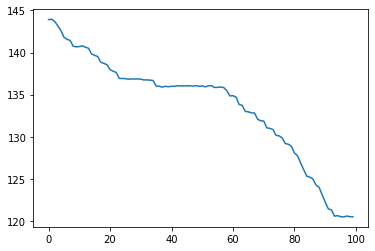

In [284]:
trajectory = pd.DataFrame(trajectory)
plt.plot(np.sqrt(trajectory[1]**2 + trajectory[0]**2))

I can visualize the steps on the trajectory clearly, I will plot the centers as a scatter plot and use a datacursor to select the locations of the steps by hand (and create a flag of 1 in those locations), this is necessary to train the algorithm.

/Users/enescaglar/anaconda3/lib/python3.7/site-packages/mpldatacursor/convenience.py:160: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cbook.iterable(axes):
/Users/enescaglar/anaconda3/lib/python3.7/site-packages/mpldatacursor/datacursor.py:140: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cbook.iterable(artists):


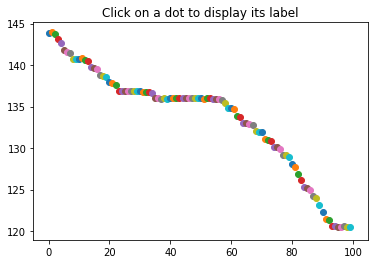

In [285]:
import matplotlib.pyplot as plt
from mpldatacursor import datacursor
import random

fig, ax = plt.subplots()
ax.set_title('Click on a dot to display its label')

for index,rows in trajectory.iterrows():
    ax.scatter([index], [np.sqrt(trajectory[1].loc[index]**2 + trajectory[0].loc[index]**2)], label='$ID: {}$'.format(rows))
# Use a DataCursor to interactively display the label.
datacursor(formatter='{label}'.format)

plt.show()

In [286]:
step_alerts = [6,9,15,18,21,24,36,60,63,65,69,72,75,78,81,85,88,92,94] #frame numbers where the protein steps takes a step.

On the position versus time plot above, I decided where the steps are by investigating with eye. The idea is that once I have enough data of where the flags for the steps are supposed to be, I can train a Machine Learning Algorithm to automatically detect the steps. Below, I am plotting the trajectory with the step size fits, dynein takes 8 nm steps but its stepping pattern is highly irregular. Furthermore, dwell times; time that passes between two consecutive steps, can also be extracted from the data. 
<br><br>Dwell time distribution is a important metric for the analysis of the stepping patterns of motor proteins in general. There are also recently published papers from our lab demonstrating/analyzing how the dwell time distribution is affacted by the presence of different types of obstacles [DeWitt et al.](https://docs.wixstatic.com/ugd/6d9b43_4cccd74299b149889b51ec5ed8a35dc4.pdf), Important analysis on the run leghts of motor proteins in the presence of obstacles by [Ferro et al.](https://elifesciences.org/articles/48629)<br><br>
I am plotting the steps in different colors to better visualize them.

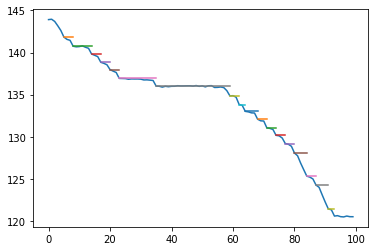

In [52]:
overall_position = np.sqrt(trajectory[1]**2 + trajectory[0]**2)
plt.plot(overall_position)
step_sizes = []
dwell_times =[]

for i in range(len(step_alerts)-1):
    x = [step_alerts[i]-1,step_alerts[i+1]-1]
    position = np.sqrt(trajectory.loc[step_alerts[i]-1][0]**2 + trajectory.loc[step_alerts[i]-1][1]**2)
    y = [position, position]
    dwell_times = np.append(dwell_times,-step_alerts[i]+step_alerts[i+1])
    if i !=0:
        step_sizes = np.append(step_sizes,temp-position)
    temp = position
    plt.plot(x,y)

My ML algorithm will have a binary target variable of either 1 or 0, 1 means that the protein takes a step at that frame in the movie. For the algorithm to detect the steps I will generate many features using the position -time (frame) plot that I have, because whether the protein steps depends on the pixel difference between where the step happens and its surrounding; I decided that it will have the following features:<br>
<br>
pos: the position of the protein (y coordinate).<br>
slope: difference between the current position and the previous position.<br>
second_slope: difference between the current position and position two frames ago.<br>
third_slope: difference between the current position and position three frames ago.<br>
fourth_slope: difference between the current position and position four frames ago.<br>
forward_slope: difference between the current position and the next position.<br>
tanhx: tanh of the difference between the previous position and the next position.<br>
tanhx2: tanh of the difference between the two previous position and the second next position.<br>
sinx: sinx of the difference between the previous position and the next position.<br>
<br>
I have 9 columns to feed the algorithm in total.<br><br>
I wrote here a function that takes the trajectory as the argument and returns a features dataframe to reuse it to generate features for different trajectories.

In [293]:
def create_features(trajectory):
    overall_position = np.sqrt(trajectory[1]**2 + trajectory[0]**2)
    
    pos = []
    slope = []
    second_slope = []
    third_slope = []
    fourth_slope = []
    forward_slope = []
    tanhx = []
    tanhx2 = []
    sinx = []
    target = []
    step_index = 0
    for i in range(4,len(overall_position)-3): #define the range such that the data can be generated for each function as we don't wanna call -2nd frame etc.
        pos = np.append(pos,overall_position[i])
        slope = np.append(slope,overall_position[i-1] - overall_position[i])
        second_slope = np.append(second_slope,overall_position[i-2] - overall_position[i])
        third_slope = np.append(third_slope,overall_position[i-3] - overall_position[i])
        fourth_slope = np.append(fourth_slope,overall_position[i-4] - overall_position[i])
        forward_slope = np.append(forward_slope,overall_position[i+1] - overall_position[i])
        tanhx = np.append(tanhx, np.tanh(overall_position[i+1] - overall_position[i-1]))
        tanhx2 = np.append(tanhx2, np.tanh(overall_position[i+2] - overall_position[i-2]))
        sinx = np.append(sinx, np.sin(overall_position[i+1] - overall_position[i-1]))
   

    features = pd.DataFrame(data = [pos,slope,second_slope,third_slope,fourth_slope,forward_slope,tanhx,tanhx2,sinx]).T
    features.columns = ['pos','slope','second_slope','third_slope','fourth_slope','forward_slope','tanhx','tanhx2','sinx']
    
    return features


Below, I create a target dataframe which is either 0 (no step) or 1.

In [294]:
for i in range(4,len(overall_position)-3): #iterating over the position to create the target flag.
    if i + 1  == step_alerts[step_index]:
        target = np.append(target, 1)
        if step_index < len(step_alerts) - 1:
            step_index = step_index + 1
    else:
        target = np.append(target, 0)
target = pd.DataFrame(target,columns = ['target'])

In [295]:
features = create_features(trajectory)

In [296]:
features.head()

,pos,slope,second_slope,third_slope,fourth_slope,forward_slope,tanhx,tanhx2,sinx
0,142.615650,0.559946,1.076046,1.335530,1.292465,-0.782568,-0.872275,-0.972054,-0.974057
1,141.833082,0.782568,1.342514,1.858614,2.118098,-0.269657,-0.782670,-0.938741,-0.868528
2,141.563425,0.269657,1.052225,1.612171,2.128271,-0.115169,-0.366891,-0.953238,-0.375398
3,141.448256,0.115169,0.384826,1.167394,1.727340,-0.698694,-0.671716,-0.819508,-0.726945
4,140.749562,0.698694,0.813863,1.083520,1.866088,-0.071799,-0.647216,-0.695270,-0.696489


In [297]:
target.head()

,target
0,0.0
1,1.0
2,0.0
3,0.0
4,1.0


There are not many 1s in my target variable, I am going to oversample these columns to account for this imbalance.

In [78]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.model_selection import train_test_split

#os = SMOTE(random_state=0)
os = RandomOverSampler()

columns = features.columns
os_data_X,os_data_y=os.fit_sample(features, target)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['target'])

/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


I am using Logistic Regression to categorize the frame numbers along the trajectory according to whether a step accurs there.

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.2, random_state=0)

lin = LogisticRegression(solver='lbfgs',multi_class='ovr')

lin.fit(X_train,y_train)

y_pred = lin.predict(X_test)

lin.score(X_test,y_test)

/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9666666666666667

Even with very few training data the algorithm is very robust and there is only 1 false positive identification according to the confusion matrix. I will see how the algorithm performs on a new trace now.

In [90]:
confusion_matrix(y_test,y_pred)

array([[16,  1],
       [ 0, 13]])

In [201]:
trajectory = extract_trajectory(2) #the new trace obtained from another image file.

This specific trace needs to be inverted because the forward position depends on the positioning of the molecular tracks (axonemes or microtubules). For now I am only analyzing the forward steps but backstepping also exist and the algorithm has to be trained for them too.

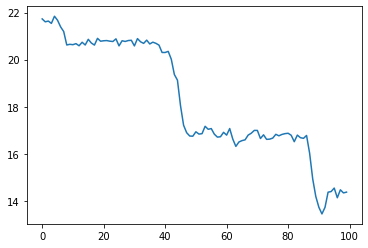

In [211]:
trajectory = pd.DataFrame(32- trajectory) 
plt.plot(np.sqrt(trajectory[1]**2 + trajectory[0]**2))

In [212]:
features = create_features(trajectory)

In [213]:
features.head() #checking the features dataframe to make sure that everything looks good.

,slope,second_slope,third_slope,fourth_slope,forward_slope,tanhx,sinx
0,-0.303059,-0.204475,-0.236775,-0.113405,-0.170042,0.132238,0.132625
1,0.170042,-0.133017,-0.034433,-0.066733,-0.281258,-0.422967,-0.436136
2,0.281258,0.451300,0.148241,0.246825,-0.197517,-0.445262,-0.460692
3,0.197517,0.478775,0.648817,0.345758,-0.571397,-0.646297,-0.695355
4,0.571397,0.768914,1.050172,1.220214,0.027597,-0.495859,-0.517391


In [214]:
step_alerts = lin.predict(features) 

In [215]:
skipped_frames = [0,0,0,0] 
skipped_frames_end = [0,0,0]
step_alerts = np.concatenate((skipped_frames,step_alerts,skipped_frames_end)) #adding the missing frames due to feature generation.

In [225]:
step_alerts

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

I will plot the trajectory and the flags at the same time to investigate if the algorithm works as expected. Note that this movie has less pixels in total and it looks more noisy for this reason compared to the initial trace.


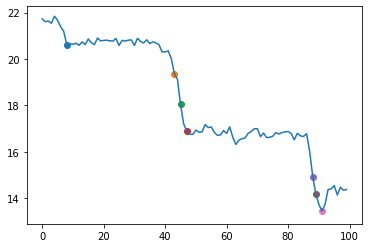

In [226]:
fig, ax = plt.subplots()

plt.plot(np.sqrt(trajectory[1]**2 + trajectory[0]**2))
for index,rows in trajectory.iterrows():
    if step_alerts[index] == 1:
        ax.scatter([index], [np.sqrt(trajectory[1].loc[index]**2 + trajectory[0].loc[index]**2)])



The algorithm works quite efficiently with the exception of accurately finding the backward steps. It gets confused when there is a backstep (around frame # 90). This step finding algorithm was obtained using very few data. Once the training is done with many more data, the resulting step finding algorithm will be much more efficient not only in finding the forward steps but also the backward steps.